https://www.kaggle.com/code/putanyn/660632067-2nd-lab-market-basket-analysis

In [5]:
from pathlib import Path
path_folder = Path("/Users/keithlowton/Desktop/Ks/Python code/Kaggle/Groceries dataset")
print(path_folder.exists())
print(path_folder)

True
/Users/keithlowton/Desktop/Ks/Python code/Kaggle/Groceries dataset


In [6]:
import datetime as dt
import os
import time
from itertools import combinations
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler


### Functions

In [7]:
def encode_values(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [8]:
def get_item_pairs(df):
    return df["Description"].tolist()

In [9]:
def run_fpgrowth_analysis(data, min_support, min_confidence):
    start_time = time.time()
    frequent_itemsets = fpgrowth(data, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    execution_time = time.time() - start_time
    return frequent_itemsets, rules, len(frequent_itemsets), len(rules), execution_time


In [10]:
def parameter_tuning(data, min_support_range, min_confidence_range):
    results = []
    for min_support in min_support_range:
        for min_confidence in min_confidence_range:
            _, _, itemsets_count, rules_count, exec_time = run_fpgrowth_analysis(data, min_support, min_confidence)
            results.append(
                {
                    "min_support": min_support,
                    "min_confidence": min_confidence,
                    "itemsets_count": itemsets_count,
                    "rules_count": rules_count,
                    "execution_time": exec_time,
                }
            )
    return pd.DataFrame(results)


In [11]:
def run_algorithm(data, min_support, min_confidence, algorithm):
    start_time = time.time()
    if algorithm == "fpgrowth":
        frequent_itemsets = fpgrowth(data, min_support=min_support, use_colnames=True)
    elif algorithm == "apriori":
        frequent_itemsets = apriori(data, min_support=min_support, use_colnames=True)
    else:
        raise ValueError("Algorithm must be either 'fpgrowth' or 'apriori'")

    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    execution_time = time.time() - start_time
    return rules, execution_time

In [12]:
def evaluate_rules(rules):
    return {
        "num_rules": len(rules),
        "avg_support": rules["support"].mean(),
        "avg_confidence": rules["confidence"].mean(),
        "avg_lift": rules["lift"].mean(),
        "max_lift": rules["lift"].max(),
    }

In [13]:
def interpret_rule(rule):
    return (
        f"If a customer buys {', '.join(rule['antecedents'])}, "
        f"they are {rule['lift']:.2f} times more likely to buy {', '.join(rule['consequents'])}. "
        f"This rule has a confidence of {rule['confidence']:.2f} and applies to {rule['support']:.2f} of transactions."
    )

### Read the data in

In [14]:

df = pd.read_excel(os.path.join(path_folder, "data/Online_Retail.xlsx"))
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [16]:
df.isna().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [17]:
df.dropna(inplace=True)
len(df)

406829

In [18]:
#Convert the InvoiceNo column to string
df["InvoiceNo"] = df["InvoiceNo"].astype('str')

#Remove rows with invoices that contain a "C"
df = df[~df["InvoiceNo"].str.contains("C")]

len(df)

397924

### EDA

In [19]:
top10 = df["Country"].value_counts().head(10)
top10

United Kingdom    354345
Germany             9042
France              8342
EIRE                7238
Spain               2485
Netherlands         2363
Belgium             2031
Switzerland         1842
Portugal            1462
Australia           1185
Name: Country, dtype: int64

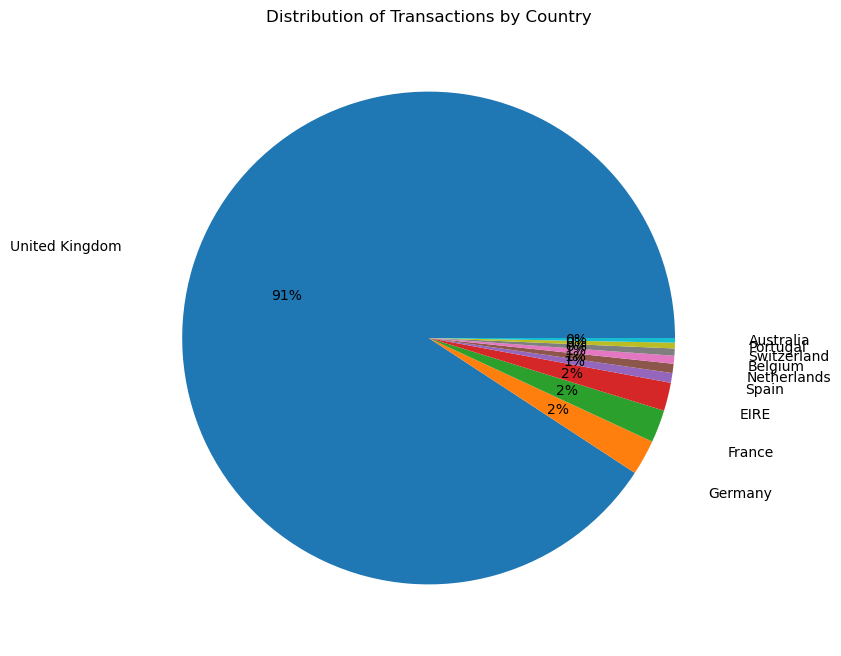

In [20]:
plt.figure(figsize=[8,8])
plt.pie(top10,labels=top10.index, autopct = '%0.0f%%',labeldistance=1.3)
plt.title("Distribution of Transactions by Country")
plt.show()

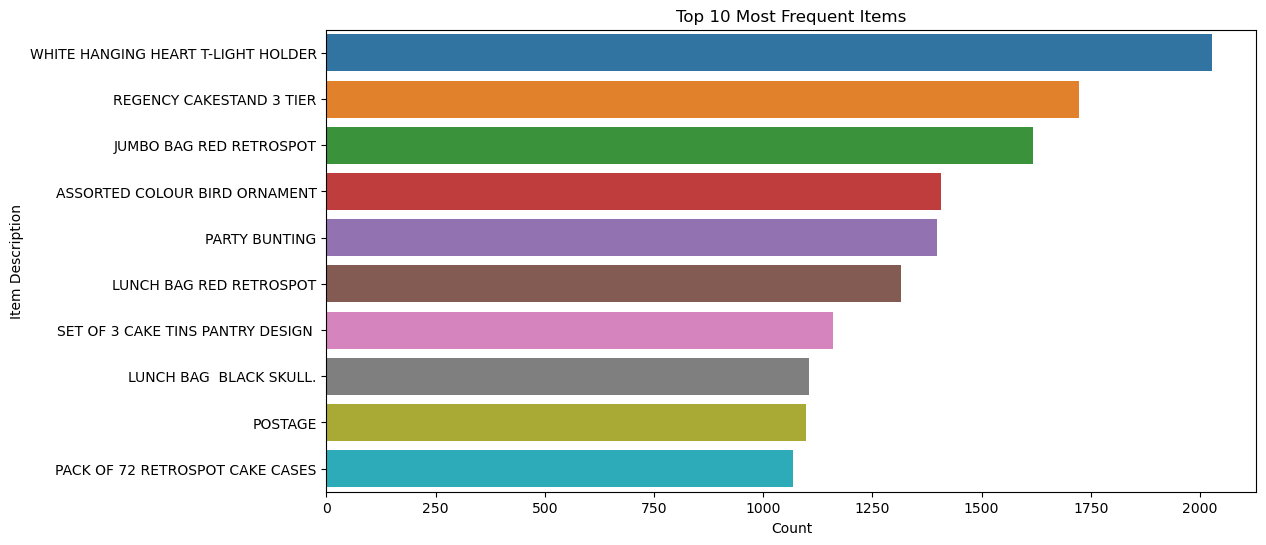

In [21]:
top_items = df["Description"].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_items.values, y=top_items.index)
plt.title('Top 10 Most Frequent Items')
plt.xlabel('Count')
plt.ylabel('Item Description')
plt.show()

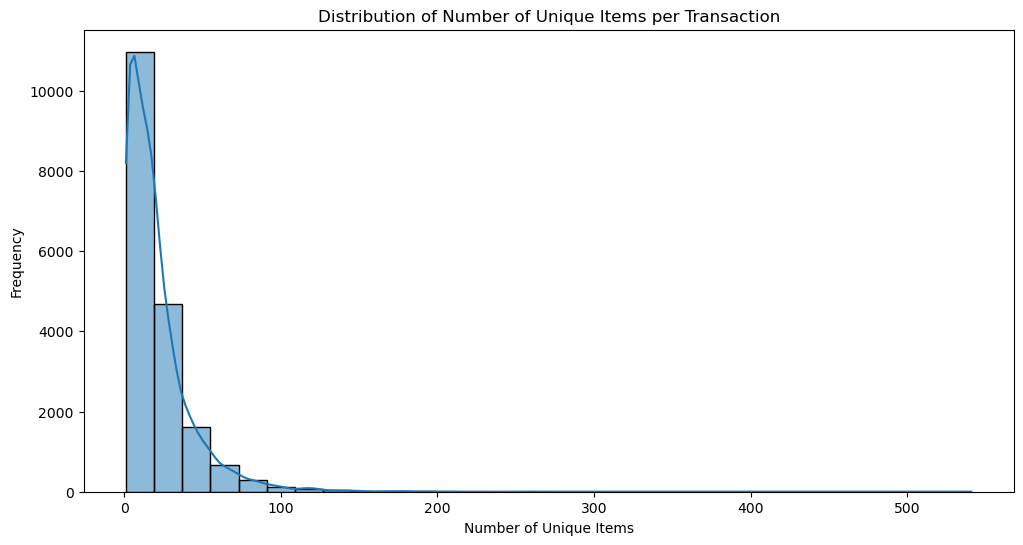

In [22]:
items_per_transaction = df.groupby("InvoiceNo")["Description"].nunique()

plt.figure(figsize=(12, 6))
sns.histplot(items_per_transaction, kde=True, bins=30)
plt.title("Distribution of Number of Unique Items per Transaction")
plt.xlabel("Number of Unique Items")
plt.ylabel("Frequency")
plt.show()


/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


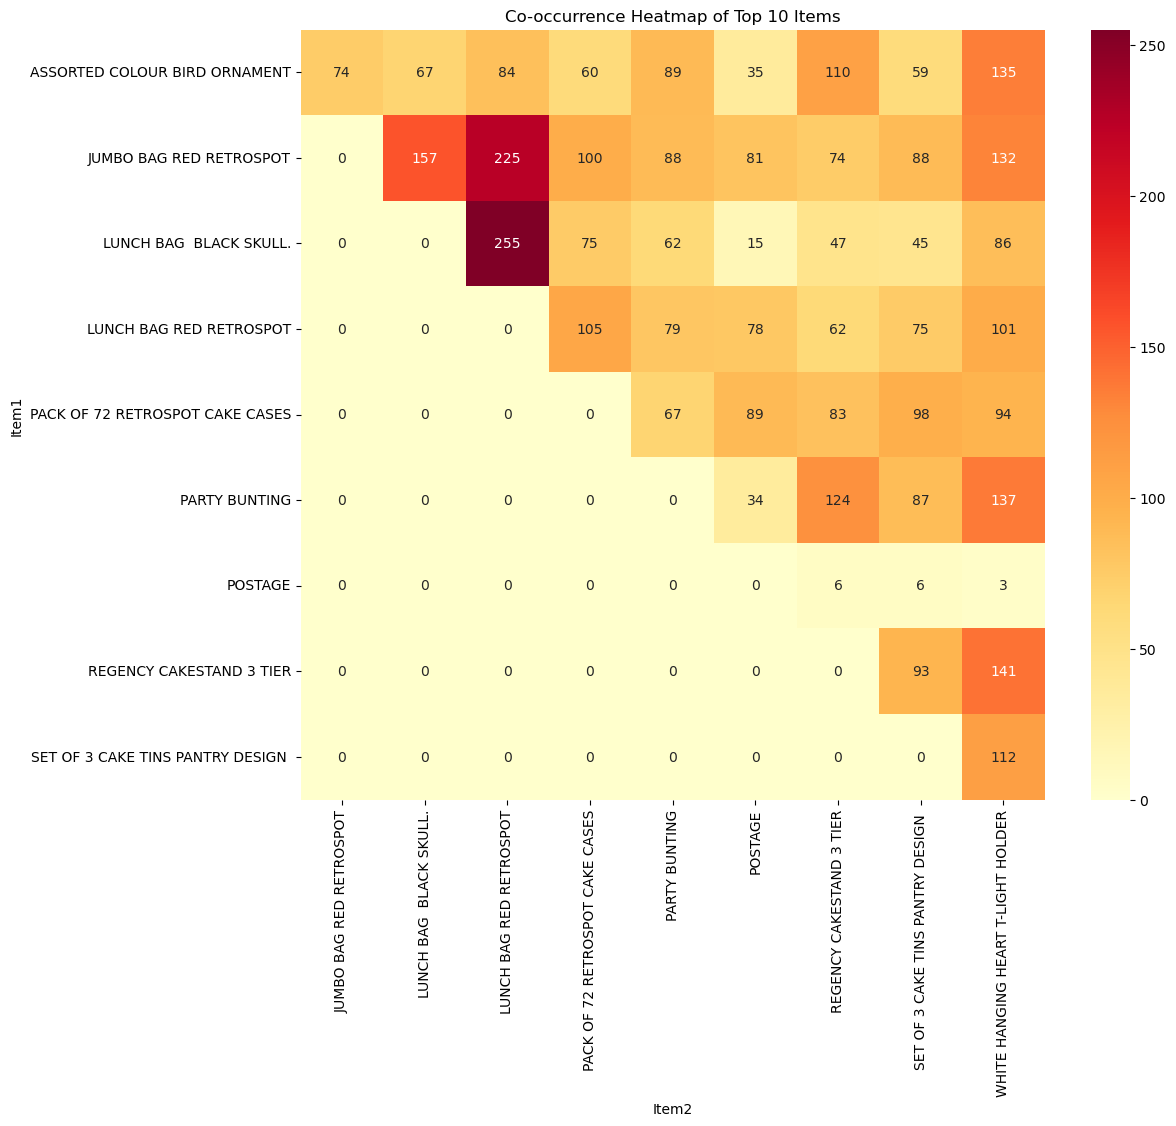

In [23]:
top_10_items = df["Description"].value_counts().nlargest(10).index
df_top_10 = df[df["Description"].isin(top_10_items)]

item_pairs = df_top_10.groupby("InvoiceNo").apply(get_item_pairs)

co_occurrence = {}

for pair in item_pairs:
    for item1, item2 in combinations(pair, 2):
        if item1 < item2:  # Avoid duplicates
            co_occurrence[(item1, item2)] = co_occurrence.get((item1, item2), 0) + 1

co_occurrence_df = pd.DataFrame(
    [(item1, item2, count) for (item1, item2), count in co_occurrence.items()], columns=["Item1", "Item2", "Count"]
)
co_occurrence_matrix = co_occurrence_df.pivot(index="Item1", columns="Item2", values="Count").fillna(0)

plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, annot=True, cmap="YlOrRd", fmt="g")
plt.title("Co-occurrence Heatmap of Top 10 Items")
plt.show()


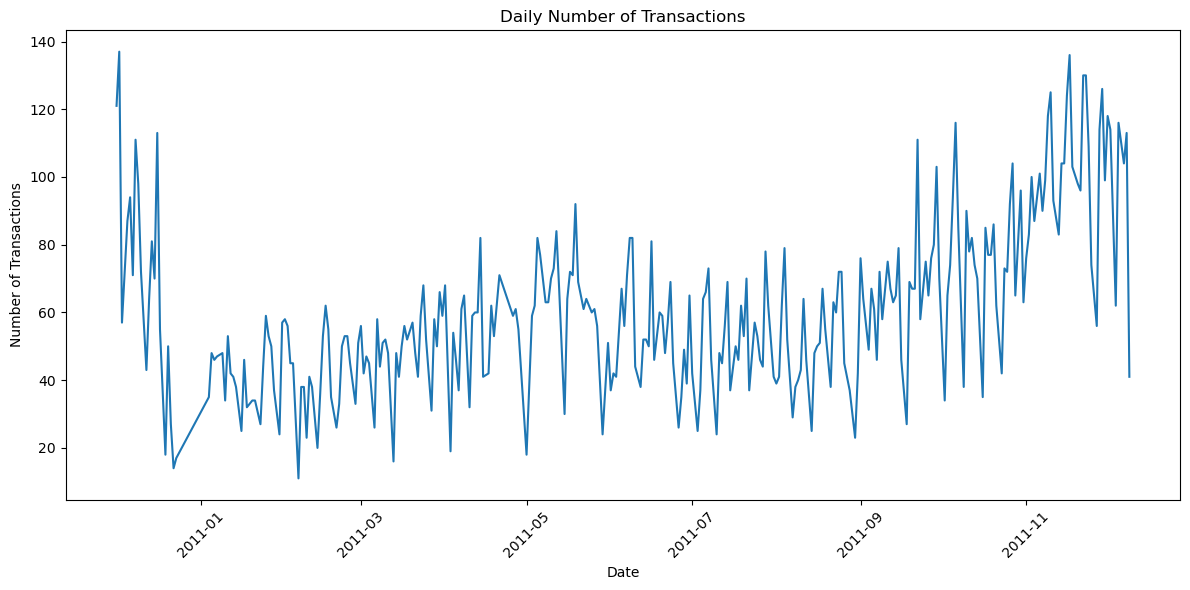

In [24]:
daily_transactions = df.groupby(df["InvoiceDate"].dt.date)["InvoiceNo"].nunique()

plt.figure(figsize=(12, 6))
plt.plot(daily_transactions.index, daily_transactions.values)
plt.title("Daily Number of Transactions")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Basket

In [25]:
basket = (
    df[df["Country"] == "United Kingdom"]
    .groupby(["InvoiceNo", "Description"])["Quantity"]
    .sum()
    .unstack()
    .reset_index()
    .fillna(0)
    .set_index("InvoiceNo")
)

basket.head()


Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
basket_encoded = basket.applymap(encode_values)

basket_encoded

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
basket_filtered = basket_encoded[(basket_encoded > 0).sum(axis=1) >= 2]

basket_filtered

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Apriori algorithm

In [28]:
frequent_itemsets = apriori(basket_filtered, min_support=0.03, use_colnames=True).sort_values("support",ascending=False)
frequent_itemsets.head(10)

/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
99,0.121358,(WHITE HANGING HEART T-LIGHT HOLDER)
44,0.093197,(JUMBO BAG RED RETROSPOT)
80,0.090466,(REGENCY CAKESTAND 3 TIER)
6,0.084417,(ASSORTED COLOUR BIRD ORNAMENT)
71,0.082986,(PARTY BUNTING)
58,0.072841,(LUNCH BAG RED RETROSPOT)
86,0.064971,(SET OF 3 CAKE TINS PANTRY DESIGN )
52,0.064646,(LUNCH BAG BLACK SKULL.)
69,0.061004,(PAPER CHAIN KIT 50'S CHRISTMAS )
64,0.060939,(NATURAL SLATE HEART CHALKBOARD )


### Asociation rules

* Support: Probability that a product set will be purchased together 
* Confidence: Conditional probability that a product is purchased if another product was purchased 
* Lift: Ratio of the observed support to that expected if the products were independent


In [29]:
assoc_rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1).sort_values("lift",ascending=False).reset_index(drop=True)
assoc_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.043900,0.039802,0.030957,0.705185,17.717202,0.029210,3.256952,0.986881
1,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.039802,0.043900,0.030957,0.777778,17.717202,0.029210,4.302452,0.982670
2,(LUNCH BAG RED RETROSPOT),(LUNCH BAG PINK POLKADOT),0.072841,0.055086,0.030632,0.420536,7.634188,0.026620,1.630668,0.937283
3,(LUNCH BAG PINK POLKADOT),(LUNCH BAG RED RETROSPOT),0.055086,0.072841,0.030632,0.556080,7.634188,0.026620,2.088574,0.919671
4,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.093197,0.052680,0.032908,0.353105,6.702899,0.027999,1.464412,0.938253
5,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.052680,0.093197,0.032908,0.624691,6.702899,0.027999,2.416152,0.898124
6,(LUNCH BAG BLACK SKULL.),(LUNCH BAG RED RETROSPOT),0.064646,0.072841,0.031478,0.486922,6.684737,0.026769,1.807051,0.909181
7,(LUNCH BAG RED RETROSPOT),(LUNCH BAG BLACK SKULL.),0.072841,0.064646,0.031478,0.432143,6.684737,0.026769,1.647164,0.917216


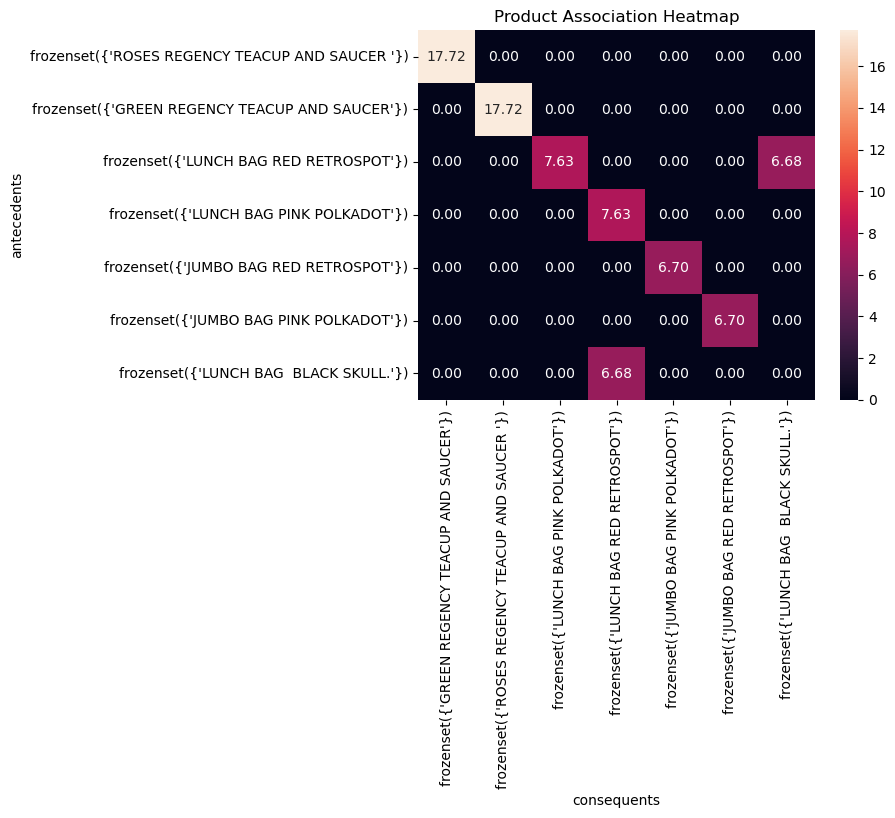

In [30]:
assoc_rules_matrix = assoc_rules.pivot(index="antecedents", columns="consequents", values="lift").fillna(0)
ax = sns.heatmap(assoc_rules_matrix, annot=True, fmt=".2f")
plt.title("Product Association Heatmap")
plt.show()

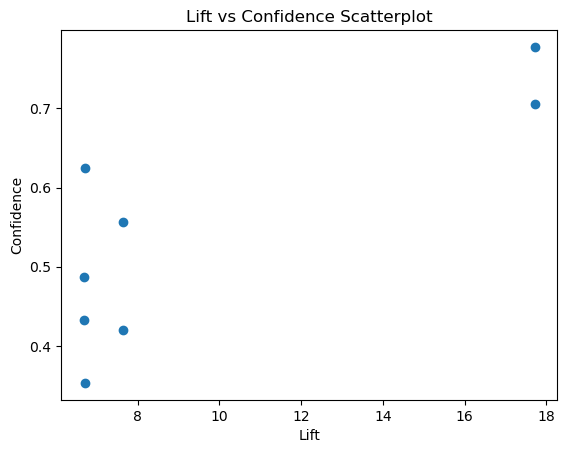

In [31]:
lift = assoc_rules.lift
confidence = assoc_rules.confidence

plt.scatter(lift, confidence)
plt.xlabel('Lift')
plt.ylabel('Confidence')
plt.title('Lift vs Confidence Scatterplot')
plt.show()

/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


TypeError: 'value' must be an instance of str or bytes, not a frozenset

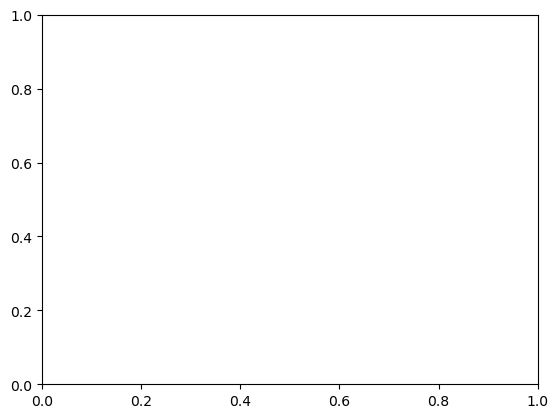

In [32]:
from pandas.plotting import parallel_coordinates

# rules contains generated association rules
parallel_coordinates(assoc_rules, 'lift')
plt.title('Parallel Coordinates of Rules')
plt.show()


### FP Growth

/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/Users/keithlowton/anaconda3/envs/Mar

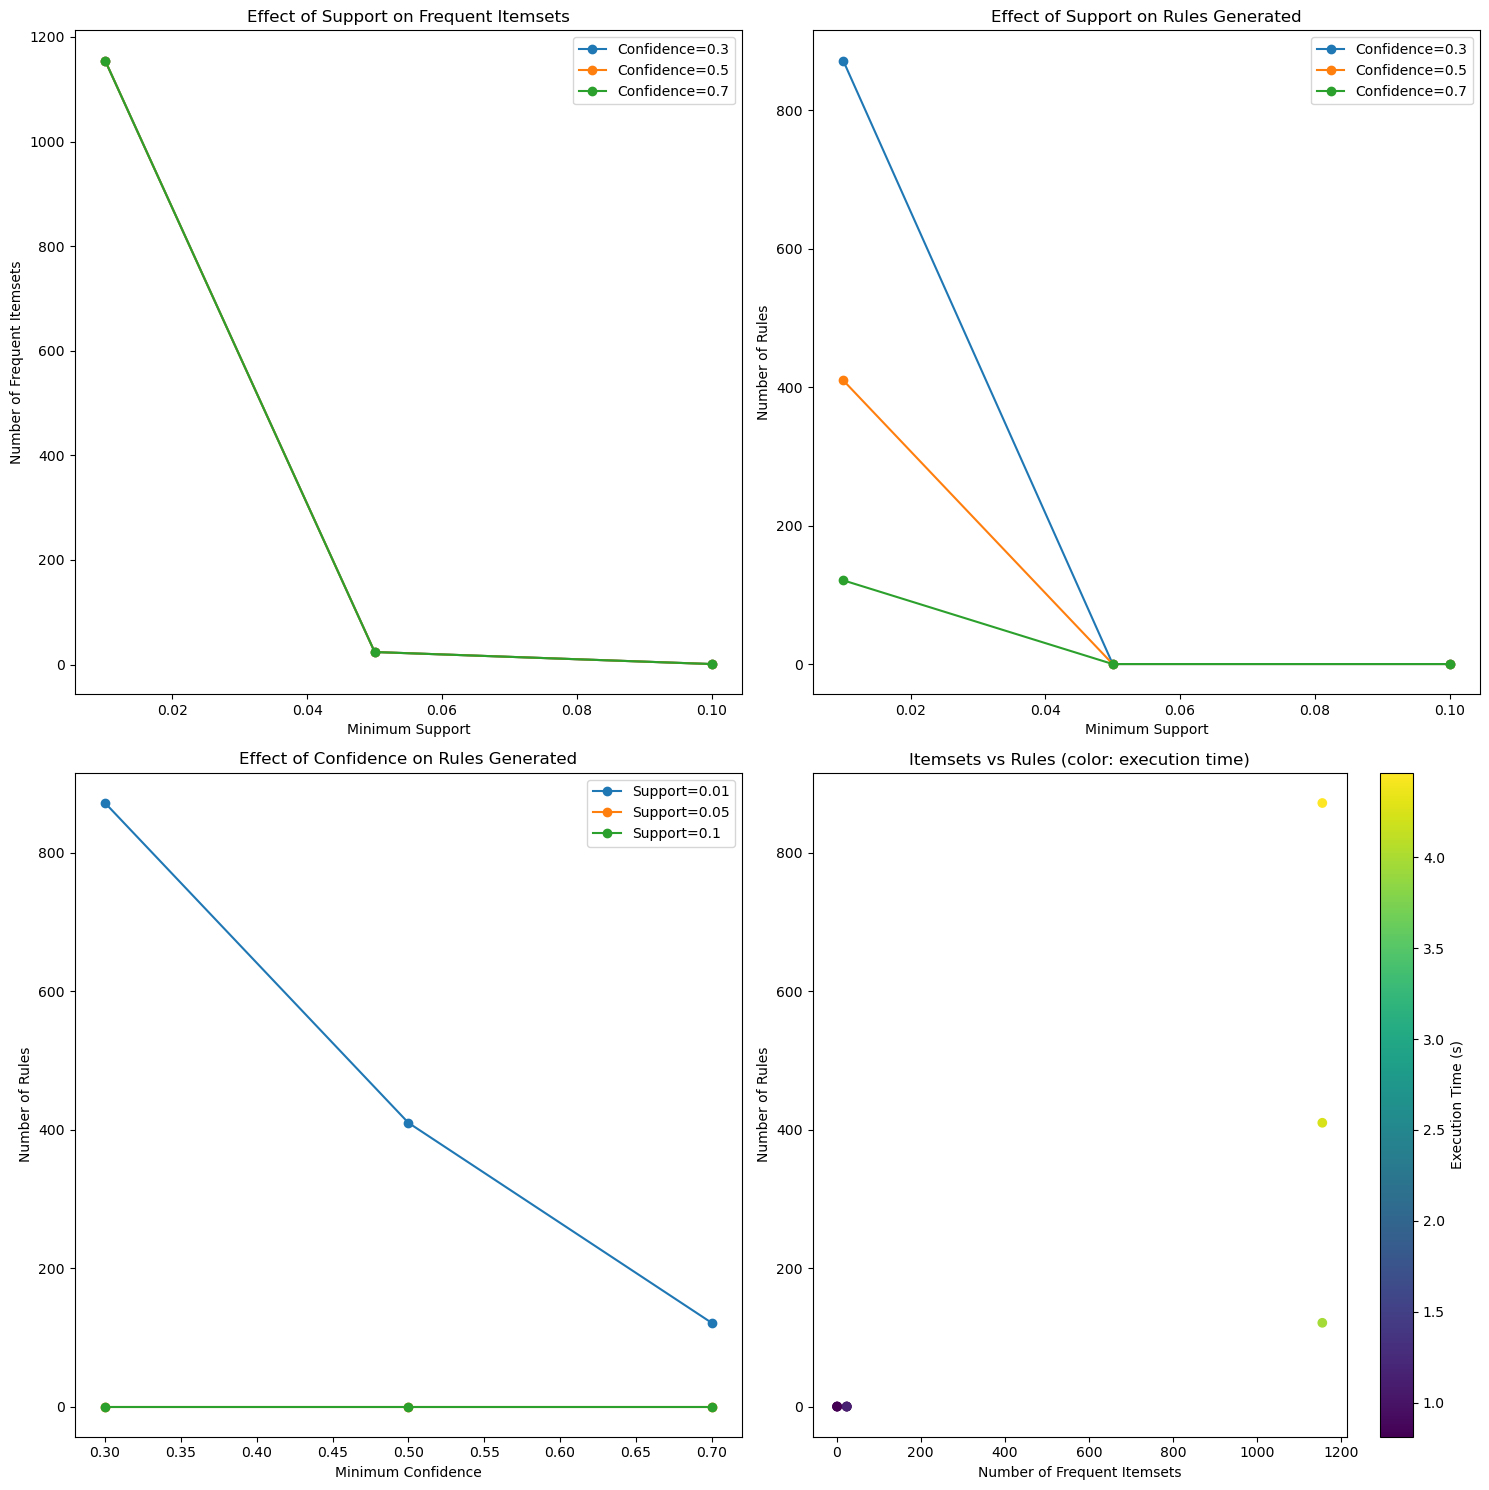

In [41]:
item_frequencies = basket_filtered.sum().sort_values(ascending=False)
top_items = item_frequencies.head(1000).index
reduced_basket = basket_filtered[top_items]

# Reduced parameter ranges
min_support_range = [0.01, 0.05, 0.1]
min_confidence_range = [0.3, 0.5, 0.7]

tuning_results = parameter_tuning(reduced_basket, min_support_range, min_confidence_range)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for confidence in min_confidence_range:
    data = tuning_results[tuning_results["min_confidence"] == confidence]
    axs[0, 0].plot(data["min_support"], data["itemsets_count"], marker="o", label=f"Confidence={confidence}")
axs[0, 0].set_xlabel("Minimum Support")
axs[0, 0].set_ylabel("Number of Frequent Itemsets")
axs[0, 0].set_title("Effect of Support on Frequent Itemsets")
axs[0, 0].legend()

for confidence in min_confidence_range:
    data = tuning_results[tuning_results["min_confidence"] == confidence]
    axs[0, 1].plot(data["min_support"], data["rules_count"], marker="o", label=f"Confidence={confidence}")
axs[0, 1].set_xlabel("Minimum Support")
axs[0, 1].set_ylabel("Number of Rules")
axs[0, 1].set_title("Effect of Support on Rules Generated")
axs[0, 1].legend()

for support in min_support_range:
    data = tuning_results[tuning_results["min_support"] == support]
    axs[1, 0].plot(data["min_confidence"], data["rules_count"], marker="o", label=f"Support={support}")
axs[1, 0].set_xlabel("Minimum Confidence")
axs[1, 0].set_ylabel("Number of Rules")
axs[1, 0].set_title("Effect of Confidence on Rules Generated")
axs[1, 0].legend()

scatter = axs[1, 1].scatter(
    tuning_results["itemsets_count"], tuning_results["rules_count"], c=tuning_results["execution_time"], cmap="viridis"
)
axs[1, 1].set_xlabel("Number of Frequent Itemsets")
axs[1, 1].set_ylabel("Number of Rules")
axs[1, 1].set_title("Itemsets vs Rules (color: execution time)")
plt.colorbar(scatter, ax=axs[1, 1], label="Execution Time (s)")

plt.tight_layout()
plt.show()


In [42]:
optimal_params = tuning_results.loc[tuning_results["rules_count"].idxmax()]
print("Optimal parameters:")
print(f"Minimum Support: {optimal_params['min_support']}")
print(f"Minimum Confidence: {optimal_params['min_confidence']}")
print(f"Number of Frequent Itemsets: {optimal_params['itemsets_count']}")
print(f"Number of Rules: {optimal_params['rules_count']}")
print(f"Execution Time: {optimal_params['execution_time']:.2f} seconds")


Optimal parameters:
Minimum Support: 0.01
Minimum Confidence: 0.3
Number of Frequent Itemsets: 1155.0
Number of Rules: 872.0
Execution Time: 4.46 seconds


/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [43]:
_, final_rules, _, _, _ = run_fpgrowth_analysis(
    reduced_basket, optimal_params["min_support"], optimal_params["min_confidence"]
)

print("\nTop 10 rules by lift using optimal parameters:")
final_rules.sort_values("lift", ascending=False).head(10)


/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Top 10 rules by lift using optimal parameters:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
443,"(HERB MARKER MINT, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010536,0.011772,0.010146,0.962963,81.803970,0.010022,26.682167,0.998294
448,(HERB MARKER ROSEMARY),"(HERB MARKER MINT, HERB MARKER THYME)",0.011772,0.010536,0.010146,0.861878,81.803970,0.010022,7.163720,0.999542
458,(HERB MARKER THYME),"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",0.011642,0.010796,0.010276,0.882682,81.759709,0.010150,8.431786,0.999404
457,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010796,0.011642,0.010276,0.951807,81.759709,0.010150,20.508438,0.998549
459,(HERB MARKER ROSEMARY),"(HERB MARKER THYME, HERB MARKER PARSLEY)",0.011772,0.010731,0.010276,0.872928,81.346325,0.010149,7.785117,0.999472
456,"(HERB MARKER THYME, HERB MARKER PARSLEY)",(HERB MARKER ROSEMARY),0.010731,0.011772,0.010276,0.957576,81.346325,0.010149,23.293955,0.998421
475,"(HERB MARKER THYME, HERB MARKER BASIL)",(HERB MARKER ROSEMARY),0.010536,0.011772,0.010081,0.956790,81.279585,0.009957,22.870429,0.998214
480,(HERB MARKER ROSEMARY),"(HERB MARKER THYME, HERB MARKER BASIL)",0.011772,0.010536,0.010081,0.856354,81.279585,0.009957,6.888192,0.999462
477,"(HERB MARKER BASIL, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010666,0.011642,0.010081,0.945122,81.185448,0.009956,18.010088,0.998331
478,(HERB MARKER THYME),"(HERB MARKER BASIL, HERB MARKER ROSEMARY)",0.011642,0.010666,0.010081,0.865922,81.185448,0.009956,7.378783,0.999316


### Comparison

In [49]:
# Select top 500 most frequent items
item_frequencies = basket_filtered.sum().sort_values(ascending=False)
top_items = item_frequencies.head(500).index
data_encoded = basket_filtered[top_items]

# Use a sample of the data
data_encoded = data_encoded.sample(frac=0.25, random_state=42)

# Use the best parameters from previous tuning
best_min_support = 0.02
best_min_confidence = 0.3

# Run algorithms
fpgrowth_rules, fpgrowth_time = run_algorithm(data_encoded, best_min_support, best_min_confidence, "fpgrowth")
apriori_rules, apriori_time = run_algorithm(data_encoded, best_min_support, best_min_confidence, "apriori")

# Evaluate results
results = {"FP-Growth": evaluate_rules(fpgrowth_rules), "Apriori": evaluate_rules(apriori_rules)}

results["FP-Growth"]["execution_time"] = fpgrowth_time
results["Apriori"]["execution_time"] = apriori_time

results_df = pd.DataFrame(results).T
results_df["algorithm"] = results_df.index
results_df = results_df.reset_index(drop=True)

print("Comparison of Algorithms:")
results_df


/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Comparison of Algorithms:


,num_rules,avg_support,avg_confidence,avg_lift,max_lift,execution_time,algorithm
0,79.0,0.025982,0.529218,10.201281,24.462103,0.594221,FP-Growth
1,79.0,0.025982,0.529218,10.201281,24.462103,1.804879,Apriori


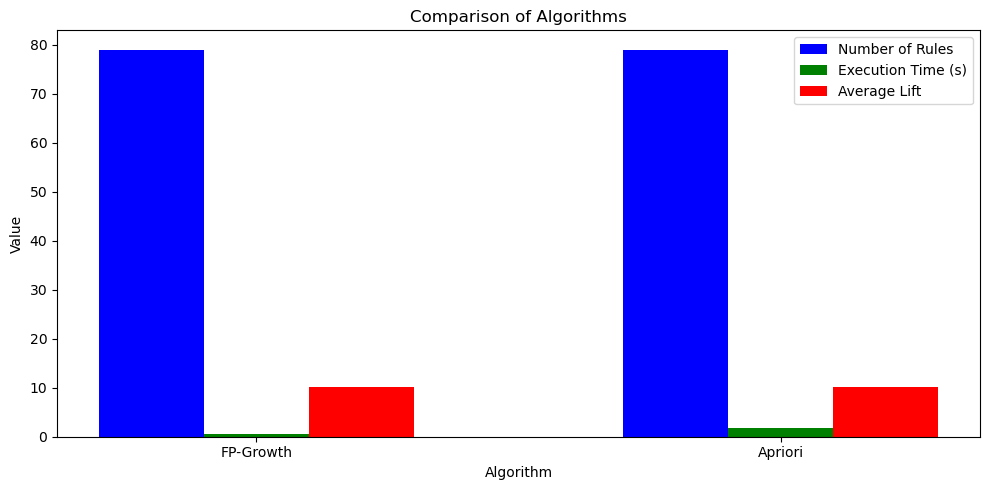

In [50]:

# Visualize comparison
plt.figure(figsize=(10, 5))
x = range(len(results_df))
width = 0.2

plt.bar([i - width for i in x], results_df["num_rules"], width, label="Number of Rules", color="blue")
plt.bar(x, results_df["execution_time"], width, label="Execution Time (s)", color="green")
plt.bar([i + width for i in x], results_df["avg_lift"], width, label="Average Lift", color="red")

plt.xlabel("Algorithm")
plt.ylabel("Value")
plt.title("Comparison of Algorithms")
plt.xticks(x, results_df["algorithm"])
plt.legend()
plt.tight_layout()
plt.show()


In [52]:

# Display top rules for the best performing algorithm (based on avg_lift)
best_algo = results_df.loc[results_df["avg_lift"].idxmax(), "algorithm"]
if best_algo == "FP-Growth":
    best_rules = fpgrowth_rules
else:
    best_rules = apriori_rules

print(f"\nTop 5 Rules by Lift for {best_algo}:")
best_rules.sort_values("lift", ascending=False).head(5)



Top 5 Rules by Lift for FP-Growth:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
54,(WOODEN HEART CHRISTMAS SCANDINAVIAN),(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.030957,0.026795,0.020291,0.655462,24.462103,0.019462,2.824668,0.989761
53,(WOODEN STAR CHRISTMAS SCANDINAVIAN),(WOODEN HEART CHRISTMAS SCANDINAVIAN),0.026795,0.030957,0.020291,0.757282,24.462103,0.019462,3.992456,0.985528
21,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.036420,0.034339,0.024974,0.685714,19.968831,0.023723,3.072557,0.985826
18,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.034339,0.036420,0.024974,0.727273,19.968831,0.023723,3.533125,0.983702
22,(GREEN REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",0.045265,0.027836,0.024974,0.551724,19.820819,0.023714,2.168674,0.994567


In [53]:

print("\nInterpretation of Top Rule:")
top_rule = best_rules.sort_values("lift", ascending=False).iloc[0]
interpret_rule(top_rule)



Interpretation of Top Rule:


/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


'If a customer buys WOODEN HEART CHRISTMAS SCANDINAVIAN, they are 24.46 times more likely to buy WOODEN STAR CHRISTMAS SCANDINAVIAN. This rule has a confidence of 0.66 and applies to 0.02 of transactions.'

**Interpretation of Segments**

**Parameter Sensitivity**:

* As minimum support increases, the number of frequent itemsets and rules generated decreases significantly. This is most pronounced at lower confidence levels (0.3).
* Lower minimum support (0.01) and confidence (0.3) values produce the highest number of rules, but may include less significant associations.
* Higher confidence levels (0.7) generate fewer rules across all support thresholds, suggesting these rules are stronger but less numerous.

**Algorithm Comparison**:

* Both FP-Growth and Apriori algorithms produced identical results in terms of number of rules (208), average support (0.0247), confidence (0.493231), and lift (8.857503).
* FP-Growth was significantly faster, with an execution time of 0.933014 seconds compared to Apriori's 2.342352 seconds.
* The maximum lift of 28.046313 indicates some very strong associations between certain items.

**Optimal Parameters**:

* The optimal parameters were found to be a minimum support of 0.01 and minimum confidence of 0.3.
* These parameters produced 1902 frequent itemsets and 1824 rules in 8.76 seconds.
* This suggests a balance between discovering a large number of associations while maintaining reasonable execution time.

**Rule Quality**:

* The average lift of 8.857503 across all rules indicates that the discovered associations are generally strong and meaningful.
* The maximum lift of 28.046313 suggests there are some product pairs with extremely strong associations.

**Executive Summary**:

* The market basket analysis revealed strong associations between certain products, with some pairs being up to 28 times more likely to be purchased together than by chance.
* FP-Growth algorithm proved to be significantly more efficient than Apriori, producing identical results in less than half the time.

**Key Findings**:

* Optimal parameters of 0.01 minimum support and 0.3 minimum confidence produced the most comprehensive set of rules.
* The average lift of 8.86 across all rules indicates generally strong associations in the dataset.

**Recommendations**:

* Implement product placement and marketing strategies based on the strongest association rules.
* Use FP-Growth for future analyses due to its superior performance.
* Develop a recommendation system for the e-commerce platform based on the discovered associations.



### Clustering

In [60]:
df.dropna(subset=["CustomerID"], inplace=True)  # Remove rows with missing CustomerID

# Remove duplicates
df.drop_duplicates(inplace=True)

# Convert necessary columns to appropriate data types
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Handling negative quantities (assuming they represent returns so right now we focus only transaction that customer actual recieve)
df = df[df["Quantity"] > 0]

# Handling outliers in the 'UnitPrice' column
df = df[(df["UnitPrice"] > 0) & (df["UnitPrice"] < df["UnitPrice"].quantile(0.99))]

# Save cleaned data
df_cleaned = df.copy()


In [62]:
df_cleaned["TotalPrice"] = df_cleaned["Quantity"] * df_cleaned["UnitPrice"]

# Encoding 'Country' as it's a categorical variable
label_encoder = LabelEncoder()
df_cleaned["Country_encoded"] = label_encoder.fit_transform(df_cleaned["Country"])

# Scaling the 'Quantity', 'UnitPrice', and 'TotalPrice' features
scaler = StandardScaler()
df_cleaned[["Quantity", "UnitPrice", "TotalPrice"]] = scaler.fit_transform(
    df_cleaned[["Quantity", "UnitPrice", "TotalPrice"]]
)


/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release

In [64]:
X = df_cleaned[["Quantity", "UnitPrice", "TotalPrice"]]

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

df_cleaned["Cluster"] = clusters


/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4

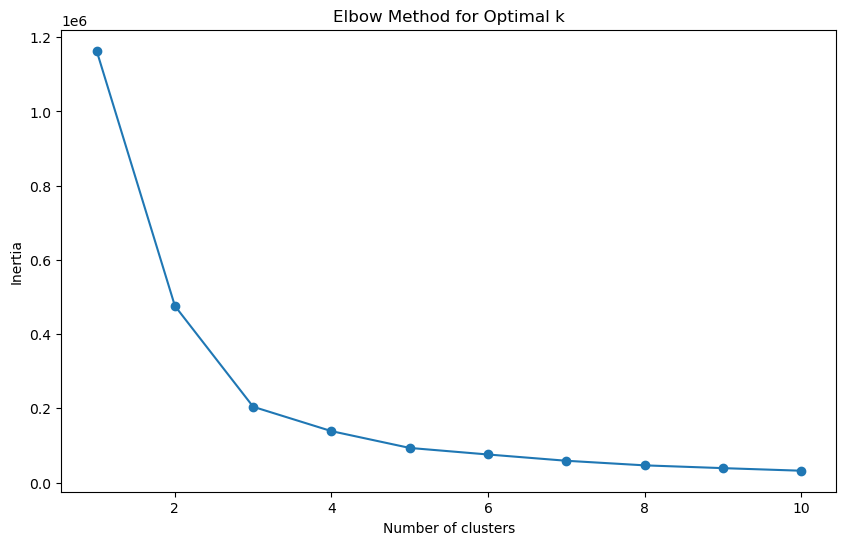

In [65]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()


In [66]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)
df_cleaned["Cluster"] = clusters


/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


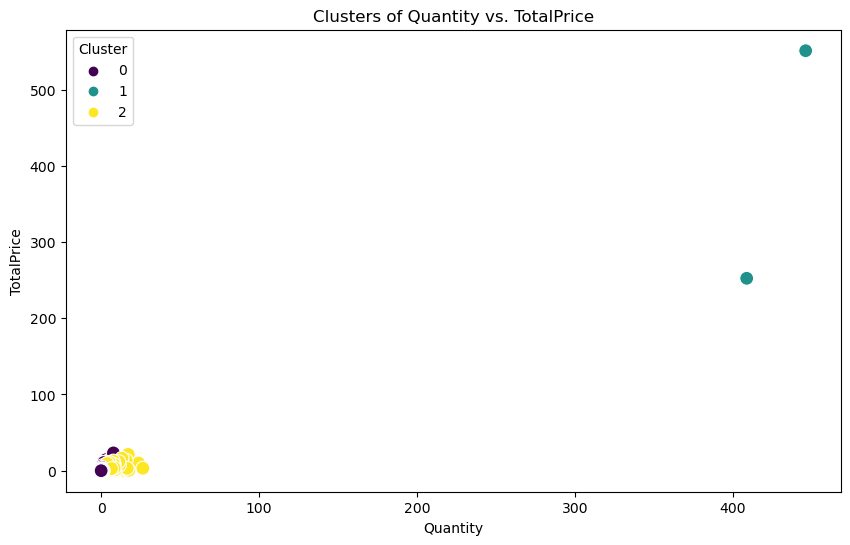

In [67]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x="Quantity", y="TotalPrice", hue="Cluster", palette="viridis", s=100)
plt.title("Clusters of Quantity vs. TotalPrice")
plt.xlabel("Quantity")
plt.ylabel("TotalPrice")
plt.show()


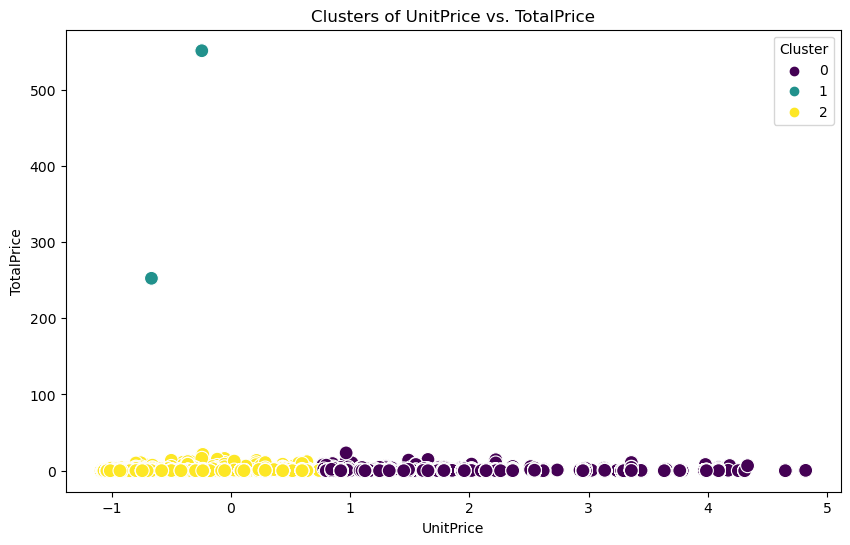

In [68]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x="UnitPrice", y="TotalPrice", hue="Cluster", palette="viridis", s=100)
plt.title("Clusters of UnitPrice vs. TotalPrice")
plt.xlabel("UnitPrice")
plt.ylabel("TotalPrice")
plt.show()

**Interpretation of Segments**

* 1st Cluster : Budget-Friendly Group (Purple Cluster) These customers buy smaller amounts of cheaper products. They care a lot about prices and might shop more often but spend less each time. They probably look for sales and lower-priced items. We should think about offering special deals or package offers for these customers. But be careful - if we raise prices, we might lose them.

* 2nd Cluster : Big Buyers Group (Teal Cluster): This group buys large amounts of more expensive products. They might be wealthy individuals or businesses that need a lot of high-quality items. They seem to care more about getting good products than about saving money. We could offer these customers special programs or exclusive products. They might also be interested in buying additional premium products.

* 3rd Cluster : Middle-Ground Group (Yellow Cluster) These customers buy medium amounts at medium prices. They're looking for a good balance between cost and quality. They might be more willing to try different products if the price is right. We should offer a variety of reasonably priced products for this group. We could also suggest new products based on what they've bought before.

**Business Implications**

**Targeted Marketing Campaigns**

*Develop specialized marketing campaigns for each segment*

The Budget-Friendly Group could be targeted with promotions and low-price guarantees. For the Big Buyers Group, focus on premium product launches and loyalty rewards. The Middle-Ground Group might respond well to messaging about value for money.
Product Development

*Tailor product offerings to each group's preferences* 

The Big Buyers Group may be interested in high-end, high-margin products. The Middle-Ground Group might prefer products balancing quality and affordability. For the Budget-Friendly Group, focus on developing cost-effective options.
Pricing Strategy

*Implement differentiated pricing strategies based on customer segments* 

Maintain competitive pricing for the Budget-Friendly Group to prevent churn. The Big Buyers Group may accept higher prices for superior quality or services. The Middle-Ground Group requires balanced pricing for good-quality products.
Customer Retention

*Create tailored retention strategies for each segment* 

Encourage the Budget-Friendly Group to increase purchases through bundle offers. Offer personalized services and exclusive rewards to the Big Buyers Group. For the Middle-Ground Group, provide a mix of value-driven deals and quality assurances.
Inventory Management

*Optimize inventory levels based on segment preferences* 

Ensure sufficient stock of premium products for the Big Buyers Group. Maintain ample supply of fast-moving, low-cost items for the Budget-Friendly Group. For the Middle-Ground Group, stock a diverse range of mid-tier products.

*Strategic Partnerships*

Form partnerships aligned with each segment's interests. Collaborate with luxury brands to appeal to the Big Buyers Group. Partner with discount retailers for the Budget-Friendly Group. For the Middle-Ground Group, seek partnerships with brands known for offering good value.

### RFM

In [69]:
df['Total'] = df['Quantity'] * df['UnitPrice']

In [72]:
latest_date = df["InvoiceDate"].max() + dt.timedelta(days=1)

rfm = (
    df.groupby("CustomerID")
    .agg({"InvoiceDate": lambda x: (latest_date - x.max()).days, "InvoiceNo": "count", "Total": "sum"})
    .reset_index()
)

rfm.rename(columns={"InvoiceDate": "Recency", "InvoiceNo": "Frequency", "Total": "MonetaryValue"}, inplace=True)


In [73]:
rfm["Recency_score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])

rfm["Frequency_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])


In [74]:
rfm["rfm_segment"] = rfm['Recency_score'].astype(str) + rfm['Frequency_score'].astype(str)
rfm.head()

,CustomerID,Recency,Frequency,MonetaryValue,Recency_score,Frequency_score,rfm_segment
0,12346.0,326,1,77183.60,1,1,11
1,12347.0,2,182,4310.00,5,5,55
2,12348.0,75,27,1437.24,2,2,22
3,12349.0,19,70,1353.80,4,4,44
4,12350.0,310,16,294.40,1,2,12


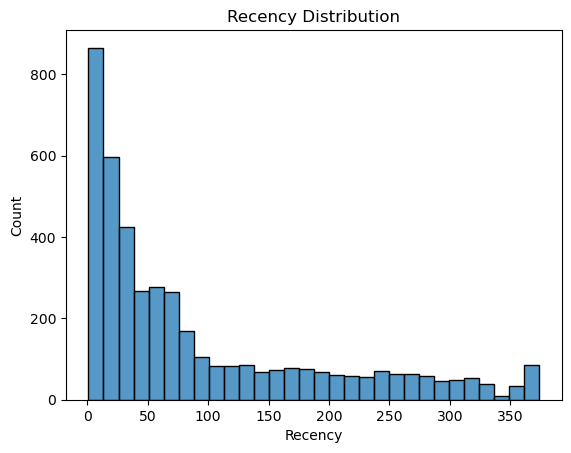

In [75]:
sns.histplot(data=rfm, x="Recency", bins=30)
plt.title("Recency Distribution")
plt.show()


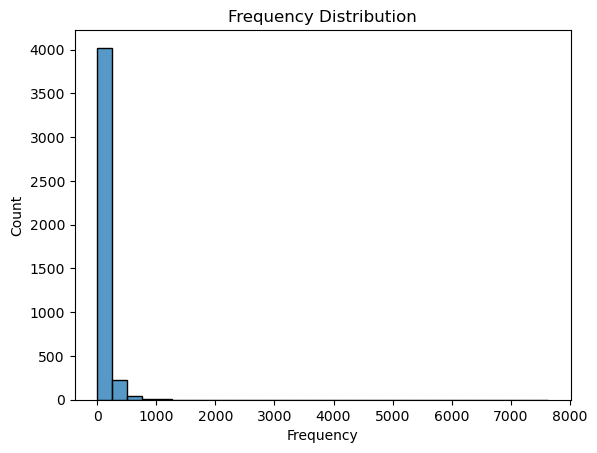

In [76]:
sns.histplot(data=rfm, x="Frequency", bins=30)
plt.title("Frequency Distribution")
plt.show()


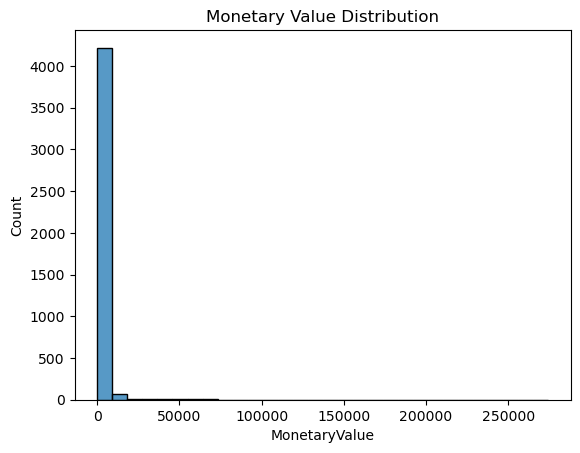

In [77]:
sns.histplot(data=rfm, x="MonetaryValue", bins=30)
plt.title("Monetary Value Distribution")
plt.show()


In [1]:
segment_map = {
    r"[1-2][1-2]": "Hibernating",
    r"[1-2][3-4]": "At-Risk",
    r"[1-2]5": "Can't Lose",
    r"3[1-2]": "About to Slip",
    r"33": "Need Attention",
    r"[3-4][4-5]": "Loyal Customers",
    r"41": "Promising",
    r"51": "New Customers",
    r"[4-5][2-3]": "Potential Loyalists",
    r"5[4-5]": "Champions",
}
rfm["rfm_segment"] = rfm["rfm_segment"].replace(segment_map, regex=True)


NameError: name 'rfm' is not defined

In [81]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "MonetaryValue"]])


/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release

In [82]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_scaled)
rfm["Cluster"] = kmeans.labels_


/Users/keithlowton/anaconda3/envs/Market_basket/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [83]:
new_rfm = rfm[["Recency", "Frequency", "MonetaryValue", "rfm_segment"]]
new_rfm.index = new_rfm.index.astype(int)
new_rfm.head()

,Recency,Frequency,MonetaryValue,rfm_segment
0,326,1,77183.60,Hibernating
1,2,182,4310.00,Champions
2,75,27,1437.24,Hibernating
3,19,70,1353.80,Loyal Customers
4,310,16,294.40,Hibernating


In [2]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Recency", y="Frequency", hue="rfm_segment", data=new_rfm, palette="viridis")
plt.title("Customer Cluster based on Recency and Frequency")
plt.show()


NameError: name 'plt' is not defined

In [3]:
segments = new_rfm["rfm_segment"].value_counts()

fig = px.bar(x=segments.index, y=segments.values, color=segments.index, text=segments.values, title="RFM Segments")
fig.update_layout(
    xaxis_title="Segment",
    yaxis_title="Count",
    font=dict(size=15, family="Arial"),
    title_font=dict(size=20, family="Arial"),
)
fig.show()


NameError: name 'new_rfm' is not defined

In [4]:
sns.set_style("darkgrid")
colors = sns.color_palette("dark")

# Create the plot
plt.figure(figsize=(15, 7))
sns.barplot(x="rfm_segment", y="Frequency", data=new_rfm, palette=colors)
plt.title("Customer Segments by Frequency", color="black", fontsize=16, fontweight="bold")
plt.xlabel("Segment", color="black", fontsize=14)
plt.ylabel("Frequency", color="black", fontsize=14)
plt.xticks(rotation=45, color="black", fontsize=12)
plt.yticks(color="black", fontsize=12)
plt.show()


NameError: name 'sns' is not defined